In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from pylab import *
from sklearn.decomposition import NMF
from seqnmf import seqnmf, plot, example_data
from scipy.spatial import distance
from skbio.stats.ordination import pcoa
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import pdist
from skbio.stats.distance import permanova
from skbio import DistanceMatrix
import matplotlib.transforms as transforms
import colorsys

# Get data

In [3]:
# read meta data
df_meta = pd.read_csv('../../../our_data/meta_data.csv', index_col=0)

# read SCFA data
df_scfa = pd.read_csv('../../../our_data/SCFA.csv', index_col=0)

# read bacterial abundance
df_bac_relab_species = pd.read_csv('../../../our_data/16S_relative_abundance_species.csv', index_col=0)
df_bac_absab_species = pd.read_csv('../../../our_data/16S_absolute_abundance_species.csv', index_col=0)

# Function to quantify individualized response

In [17]:
def plot_reconstruction(
    df_meta, # meta data
    df_var,  # response data
    var_name, # variable to decompose
    method,  # seqNMF or NMF
    diet,    # to which diet response was concerned
    nc,    # number of components
    logy=False,  # log scale of y axis
    ylim=None, # limit of yaxis
    savefig=False # whether save figure
):
    fig,ax=plt.subplots(len(nc)*len(var_name), 4, figsize=(12,2*len(nc)*len(var_name)), sharex=True, sharey='row', squeeze=False)
    
    for i1, var_name_ in enumerate(var_name):
        
        # join meta data and variables
        # df_meta_var has dimension miceID * time
        df_meta_var = pd.merge(deepcopy(df_meta), deepcopy(df_var[[var_name_]]), left_index=True, right_index=True, how='inner')
        df_meta_var = df_meta_var[df_meta_var.Diet.isin([diet,'Control'])]
        df_meta_var = pd.pivot_table(df_meta_var, columns='Day', index='MiceID', values=var_name_)
        df_meta_var = df_meta_var.dropna(axis=1, how='all')

        # intrapolation for missing data
        for subject in df_meta_var.index:
            df_tmp = df_meta_var.loc[subject].dropna()
            x = list(df_tmp.index)
            y = list(df_tmp.values)
            if len(x)==1:
                # only single datapoint
                continue
            if len(x)>=2:
                f = InterpolatedUnivariateSpline(x, y, k=1)
                df_meta_var.loc[subject,:] = f(list(df_meta_var.columns))
        df_meta_var = df_meta_var.clip(lower=1e-100) # set negative values to zero
        assert df_meta_var.min().min()>=0
        assert np.all(df_meta_var.values >= 0)

        # normalize max to 1
        normalization_factor = df_meta_var.max().max()
        df_meta_var = df_meta_var/normalization_factor

        # data decomposition
        for i2, nc_ in enumerate(nc):
            i = i1*len(nc)+i2
            
            if method=='seqNMF':
                np.random.seed(0)
                [W, H, cost, loadings, power] = seqnmf(df_meta_var.values, K=nc_, L=1, Lambda=0, plot_it=False, shift=False, max_iter=1000)
                W=W[:,:,0]
            elif method=='NMF':
                model = NMF(n_components=nc_, init='random', random_state=0, tol=1e-6, l1_ratio=1, alpha=0)
                W = model.fit_transform(df_meta_var.values)
                H = model.components_
            else:
                print('unknown method: ^%s'%(method))
                raise
            df_meta_var_reconstructed = pd.DataFrame(np.dot(W,H), index=df_meta_var.index, columns=df_meta_var.columns)

            # plot
            for j,vendor in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
                mice_from_this_vendor = list(set(df_meta.loc[(df_meta.Vendor==vendor)&(df_meta.Diet=='Resistant starch'), 'MiceID']))
                colors = ['#FFB300', # Vivid Yellow,
                          '#803E75', # Strong Purple
                          '#FF6800', # Vivid Orange
                          '#A6BDD7', # Very Light Blue
                          '#C10020'] # Vivid Red'
                for k,mouse in enumerate(mice_from_this_vendor):
                    if mouse in list(df_meta_var.index):
                        _ = ax[i,j].scatter(df_meta_var.columns, df_meta_var.loc[mouse]*normalization_factor, color=colors[k], s=30)
                        _ = ax[i,j].plot(df_meta_var_reconstructed.columns, df_meta_var_reconstructed.loc[mouse]*normalization_factor, color=colors[k])
                _ = ax[i,j].set_xlabel('Day')
                _ = ax[i,j].set_ylabel('%s'%(var_name_))
                _ = ax[i,j].set_title('%s,%s,nc=%d'%(var_name_,vendor,nc_))
                
                if logy:
                    _ = ax[i,j].set_yscale('log')
                if ylim is not None:
                    _ = ax[i,j].set_ylim(ylim)
            
    plt.tight_layout()
    
    if savefig:
        plt.rcParams['svg.fonttype'] = 'none'
        fig.savefig("individualized_response_reconstruction_%s.svg"%(diet), format="svg")
    
    return fig,ax

In [5]:
def confidence_ellipse(x, y, ax, n_std=2, facecolor='none', **kwargs):
        """
        Create a plot of the covariance confidence ellipse of *x* and *y*.

        Parameters
        ----------
        x, y : array-like, shape (n, )
            Input data.

        ax : matplotlib.axes.Axes
            The axes object to draw the ellipse into.

        n_std : float
            The number of standard deviations to determine the ellipse's radiuses.

        **kwargs
            Forwarded to `~matplotlib.patches.Ellipse`

        Returns
        -------
        matplotlib.patches.Ellipse
        """
        if x.size != y.size:
            raise ValueError("x and y must be the same size")

        cov = np.cov(x, y)
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                          facecolor=facecolor, **kwargs)

        # Calculating the stdandard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = np.mean(x)

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = np.mean(y)

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        if ax is not None:
            ellipse.set_transform(transf + ax.transData)
            _ = ax.add_patch(ellipse)
        return mean_x, mean_y




In [6]:
def quantify_individualized_response(
    df_meta, # meta data
    df_var,  # variables to decompose
    diet,    # to which diet response was concerned
    method='seqNMF', # decomposition method, options include seqNMF, NMF, PCoA
                     # PCoA should not be used because it is not a factor analysis. We include it for control purposes.
    nc=2,    # number of components
    metric='minkowski', # distance metric
    center=True, # whether centralize control group
    plotfig=False, # whether plot figure
    savefig=False, # whether save figure
    xlim=None, # xaxis limit
    ylim=None,  # yaxis limit
    permutations=None, # dict: some variables requires much higher permutation numbers
    max_permutation_number=999, # maximum permutation number if permutations are not set
    print_power=True # whether to print total power of factorization for seqNMF
):
    if plotfig:
        fig,ax=plt.subplots(1,len(df_var.columns),figsize=(3*len(df_var.columns),3), squeeze=False)
    
    stats_summary = []
    for k,var_name in enumerate(df_var.columns):
        #print(var_name)
        
        # join meta data and variables
        # df_meta_var has dimension miceID * time
        df_meta_var = pd.merge(deepcopy(df_meta), deepcopy(df_var[[var_name]]), left_index=True, right_index=True, how='inner')
        df_meta_var = df_meta_var[df_meta_var.Diet.isin([diet,'Control'])]
        df_meta_var = pd.pivot_table(df_meta_var, columns='Day', index='MiceID', values=var_name)
        df_meta_var = df_meta_var.dropna(axis=1, how='all')

        # intrapolation for missing data
        for subject in df_meta_var.index:
            df_tmp = df_meta_var.loc[subject].dropna()
            x = list(df_tmp.index)
            y = list(df_tmp.values)
            if len(x)==1:
                # only single datapoint
                continue
            if len(x)>=2:
                f = InterpolatedUnivariateSpline(x, y, k=1)
                df_meta_var.loc[subject,:] = f(list(df_meta_var.columns))
        df_meta_var = df_meta_var.clip(lower=1e-100) # set negative values to zero
        assert df_meta_var.min().min()>=0
        assert np.all(df_meta_var.values >= 0)
        
        # normalize max to 1
        normalization_factor = df_meta_var.max().max()
        df_meta_var = df_meta_var/normalization_factor
                
        # data decomposition
        if method=='NMF':
            model = NMF(n_components=nc, init='random', random_state=0, tol=1e-6, l1_ratio=1, alpha=0)
            W = model.fit_transform(df_meta_var.values)
            loadings = None
            df_W = pd.DataFrame(W, index=df_meta_var.index)
        if method=='seqNMF':
            np.random.seed(0)
            [W, H, cost, loadings, power] = seqnmf(df_meta_var.values, K=nc, L=1, Lambda=0, plot_it=False, shift=False, max_iter=1000)
            W=W[:,:,0]
            df_W = pd.DataFrame(W, index=df_meta_var.index)
            if print_power:
                print('%s, power = %2.2f'%(var_name, power))
        if method=='PCoA':
            dm = distance.squareform(distance.pdist(df_meta_var, metric=metric))
            df_dm = pd.DataFrame(dm, index = df_meta_var.index, columns = df_meta_var.index)
            OR = pcoa(df_dm.values, number_of_dimensions=nc)
            loadings = list(OR.proportion_explained)
            df_W = pd.DataFrame(OR.samples.values, index=df_meta_var.index)

        if len(df_W)==0 or df_W.isnull().values.any():
            continue
                    
        df_W = df_W.stack().to_frame().reset_index()
        df_W.columns = ['MiceID','PC','Weights']
        df_W = pd.merge(df_W, df_meta[['MiceID','Vendor','Diet']].drop_duplicates(), left_on='MiceID', right_on='MiceID', how='inner')
        df_W = pd.pivot_table(df_W, columns='PC', index=['MiceID','Vendor','Diet'], values='Weights').reset_index()
        #print(df_W)
        
        # rank vendors
        df_W = df_W.sort_values(by='Vendor')
        all_vendors = list(set(df_W.Vendor))
        vendor_colors={'Beijing':'#1f77b4', 'Guangdong':'#ff7f0e', 'Hunan':'#2ca02c', 'Shanghai':'#d62728'}
    
        # centralize data by moving control group average to zero
        df_W_centered = deepcopy(df_W)
        if center:
            for vendor in all_vendors:
                # control
                df_W_ctr = df_W[(df_W.Vendor==vendor)&(df_W.Diet=='Control')]
                df_W_ctr_mean = df_W_ctr.mean()
                for PC in np.arange(0,nc):
                    df_W_centered.loc[(df_W_centered.Vendor==vendor)&(df_W_centered.Diet=='Control'),PC] = df_W_centered.loc[(df_W_centered.Vendor==vendor)&(df_W_centered.Diet=='Control'),PC]-df_W_ctr_mean[PC]
                    df_W_centered.loc[(df_W_centered.Vendor==vendor)&(df_W_centered.Diet==diet),PC] = df_W_centered.loc[(df_W_centered.Vendor==vendor)&(df_W_centered.Diet==diet),PC]-df_W_ctr_mean[PC]

        # test significant difference
        df_W_centered_diet = df_W_centered[df_W_centered.Diet==diet]
        dm = pdist(np.asarray(df_W_centered_diet[np.arange(0,nc)].values), metric=metric, w=loadings)
        DM = DistanceMatrix(dm,list(df_W_centered_diet.MiceID))
        if permutations is not None and var_name in permutations.keys():
            stats = permanova(DM, grouping=list(df_W_centered_diet.Vendor), permutations=permutations[var_name])
        else:
            stats = permanova(DM, grouping=list(df_W_centered_diet.Vendor), permutations=999)
            for pmn in 10**np.arange(4,19)-1:
                if pmn > max_permutation_number:
                    break
                else:
                    stats = permanova(DM, grouping=list(df_W_centered_diet.Vendor), permutations=pmn)
                    if stats['p-value'] > 1/(1+pmn)+1e-10:
                        break
        stats_summary.append([var_name, stats['test statistic'], stats['p-value']])
        
        # plot
        if plotfig:
            # keep the top2 factors
            df_W_centered_top2 = df_W_centered.loc[:,['MiceID','Vendor','Diet',0,1]]
            df_W_centered_top2.columns = ['MiceID','Vendor','Diet','Factor_1','Factor_2']
            for vendor in all_vendors:
                # control
                df_W_centered_ctr = df_W_centered_top2[(df_W_centered_top2.Vendor==vendor)&(df_W_centered_top2.Diet=='Control')]
                var_ctr = df_W_centered_ctr[['Factor_1','Factor_2']].var()

                # diet
                df_W_centered_diet = df_W_centered_top2[(df_W_centered_top2.Vendor==vendor)&(df_W_centered_top2.Diet==diet)]
                var_diet = df_W_centered_diet[['Factor_1','Factor_2']].var()
                
                # plot eclipse
                if var_ctr.min()>1e-100 and var_diet.min()>1e-100:
                    mean_x_ctr, mean_y_ctr = confidence_ellipse(df_W_centered_ctr.Factor_1, df_W_centered_ctr.Factor_2, ax[0,k], edgecolor=None, facecolor=vendor_colors[vendor], alpha=0.3)
                    mean_x_diet, mean_y_diet = confidence_ellipse(df_W_centered_diet.Factor_1, df_W_centered_diet.Factor_2, ax[0,k], edgecolor=None, facecolor=vendor_colors[vendor], alpha=0.3)
                else:
                    mean_x_ctr  = np.mean(df_W_centered_ctr.Factor_1)
                    mean_y_ctr  = np.mean(df_W_centered_ctr.Factor_2)
                    mean_x_diet = np.mean(df_W_centered_diet.Factor_1)
                    mean_y_diet = np.mean(df_W_centered_diet.Factor_2)
                
                # plot an arrow pointing from control to diet
                ax[0,k].annotate(text='', xy=(mean_x_ctr,mean_y_ctr), xytext=(mean_x_diet,mean_y_diet), arrowprops=dict(arrowstyle='<-,head_length=1, head_width=1',color=vendor_colors[vendor], lw=3))

            _ = sns.scatterplot(x='Factor_1', y='Factor_2', hue='Vendor', style='Diet', s=100, data=df_W_centered_top2, ax=ax[0,k])
            _ = ax[0,k].set_title('%s, S=%2.2f, P=%2.6f'%(var_name, stats['test statistic'], stats['p-value']))
            if loadings is not None:
                _ = ax[0,k].set_xlabel('Factor 1 (%2.2f)'%(loadings[0]*100))
                _ = ax[0,k].set_ylabel('Factor 2 (%2.2f)'%(loadings[1]*100))
            else:
                _ = ax[0,k].set_xlabel('Factor 1')
                _ = ax[0,k].set_ylabel('Factor 2')
            if xlim is not None:
                ax[0,k].set_xlim(xlim)
            if ylim is not None:
                ax[0,k].set_ylim(ylim)
            if center and xlim is not None and ylim is not None:
                ax[0,k].plot(xlim,[0,0],'k--')
                ax[0,k].plot([0,0],ylim,'k--')
    
    if plotfig:
        plt.tight_layout()
    
    # save figure
    if savefig:
        plt.rcParams['svg.fonttype'] = 'none'
        fig.savefig("individualized_response_2d_visualization_%s.svg"%(diet), format="svg")

    df_stats = pd.DataFrame(stats_summary, columns=['Variable','Statistic','P-value'])
    df_stats['log10(P-value)'] = np.log10(df_stats['P-value'])
    if plotfig:
        return fig, df_stats
    else:
        return None, df_stats

# SCFA

Acetate, power = 0.88
Propionate, power = 0.91
Butyrate, power = 0.89
Total, power = 0.89


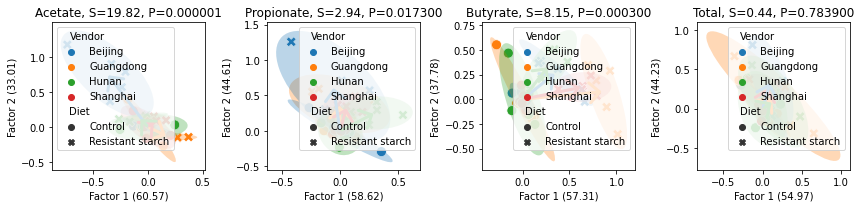

In [7]:
fig, df_stats_scfa = quantify_individualized_response(
    df_meta, 
    df_scfa, 
    diet='Resistant starch',
    plotfig=True, 
    savefig=True, 
    max_permutation_number=999999
)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


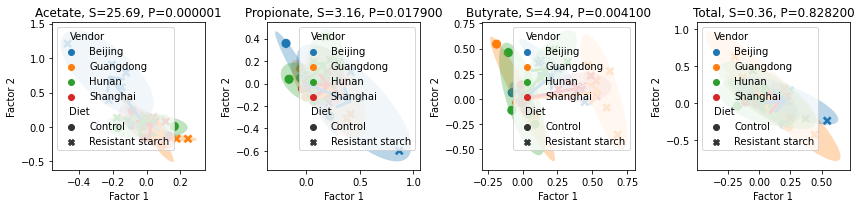

In [9]:
fig, df_stats_scfa = quantify_individualized_response(
    df_meta, 
    df_scfa, 
    diet='Resistant starch',
    method='NMF',
    plotfig=True, 
    savefig=True, 
    max_permutation_number=999999
)

## test effects of number of components

number of components = 1
Acetate, power = 0.83
Propionate, power = 0.88
Butyrate, power = 0.85
Total, power = 0.86


number of components = 2
Acetate, power = 0.88
Propionate, power = 0.91
Butyrate, power = 0.89
Total, power = 0.89


number of components = 3
Acetate, power = 0.92
Propionate, power = 0.93
Butyrate, power = 0.93
Total, power = 0.93


number of components = 4
Acetate, power = 0.95
Propionate, power = 0.95
Butyrate, power = 0.95
Total, power = 0.95


number of components = 5
Acetate, power = 0.97
Propionate, power = 0.97
Butyrate, power = 0.96
Total, power = 0.97


number of components = 6
Acetate, power = 0.98
Propionate, power = 0.98
Butyrate, power = 0.98
Total, power = 0.98


number of components = 7
Acetate, power = 0.99
Propionate, power = 0.99
Butyrate, power = 0.99
Total, power = 0.99


number of components = 8
Acetate, power = 0.99
Propionate, power = 0.99
Butyrate, power = 0.99
Total, power = 1.00


number of components = 9
Acetate, power = 1.00
Propionate, power

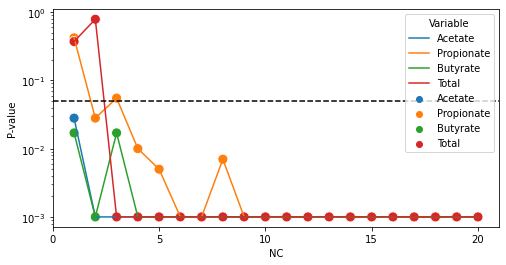

In [10]:
n_components=np.arange(1,21)
df_stats = None
for nc in n_components:
    print('number of components = %d'%(nc))
    _, df_tmp = quantify_individualized_response(df_meta, df_scfa, diet='Resistant starch', nc=nc, max_permutation_number=999)
    print('\n')
    
    df_tmp['NC'] = nc
    if df_stats is None:
        df_stats = deepcopy(df_tmp)
    else:
        df_stats = pd.concat([df_stats, df_tmp], ignore_index=True)

fig,ax=plt.subplots(1,1,figsize=(8,4))
_ = sns.lineplot(x='NC', y='P-value', hue='Variable', data=df_stats, ax=ax)
_ = sns.scatterplot(x='NC', y='P-value', hue='Variable', data=df_stats, ax=ax, s=[100]*len(df_stats))
_ = ax.plot([0,21],[0.05,0.05],'k--')
_ = ax.set_yscale('log')
_ = ax.set_xlim([0,21])
_ = ax.set_xticks([0,5,10,15,20])

# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("p_value_at_varied_component_number.svg", format="svg")

## check reconstructions

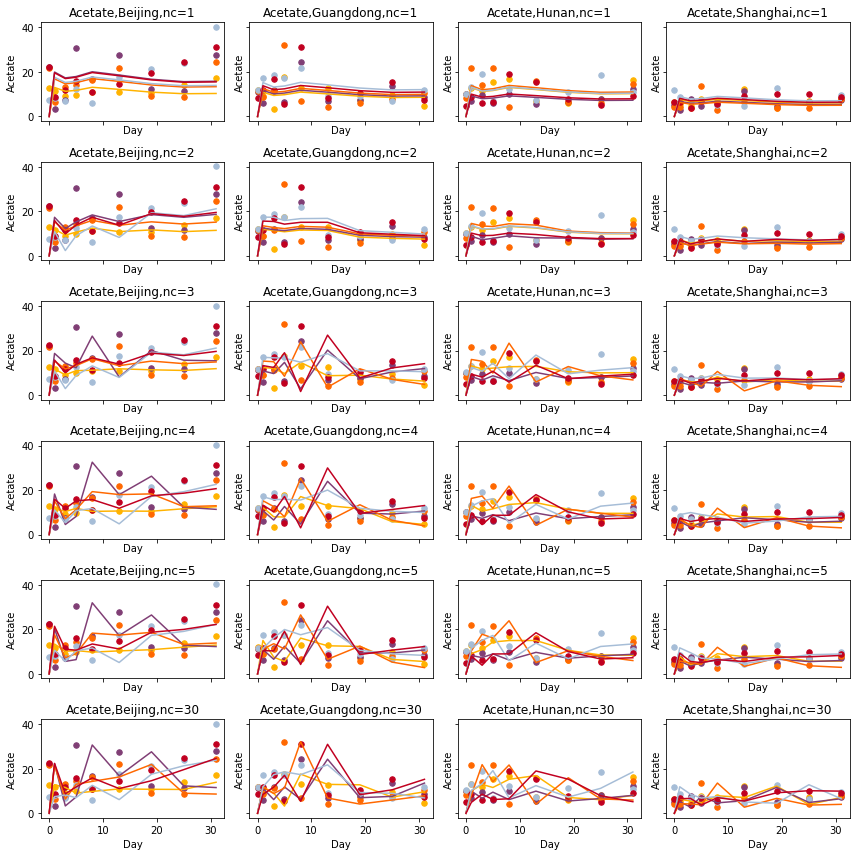

In [18]:
_,_ = plot_reconstruction(
    df_meta=df_meta, # meta data
    df_var=df_scfa,  # response data
    var_name=['Acetate'], # variable to decompose
    method='seqNMF', # seqNMF or NMF
    diet='Resistant starch',    # to which diet response was concerned
    nc=[1,2,3,4,5,30]    # number of components
)

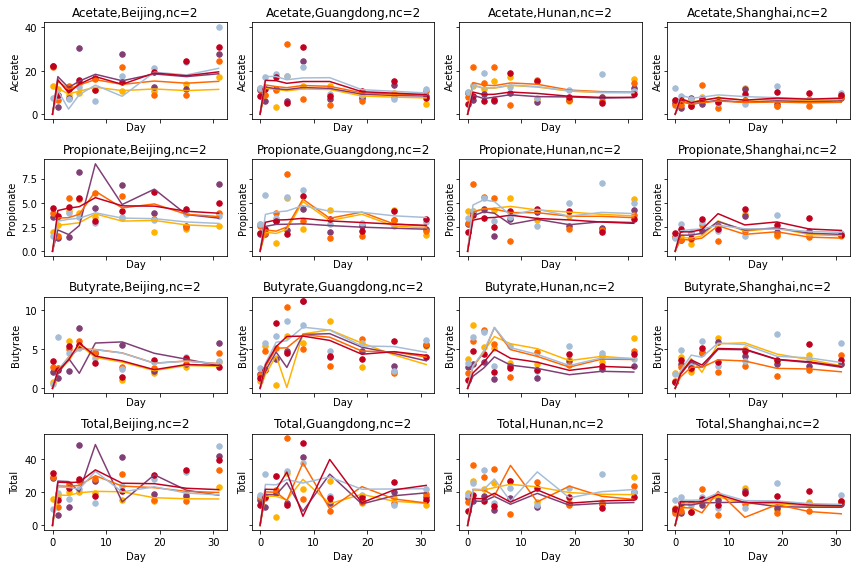

In [19]:
_,_ = plot_reconstruction(
    df_meta=df_meta, # meta data
    df_var=df_scfa,  # response data
    var_name=['Acetate','Propionate','Butyrate','Total'], # variable to decompose
    method='seqNMF', # seqNMF or NMF
    diet='Resistant starch',    # to which diet response was concerned
    nc=[2],    # number of components
    savefig=True
)

# Bacteria (species level)

## relative abundance

In [ ]:
_, df_stats_relab_species = quantify_individualized_response(
    df_meta, 
    df_bac_relab_species, 
    diet='Resistant starch', 
    plotfig=False,
    print_power = False,
    max_permutation_number=999999
)
df_stats_relab_species.to_csv('individualized_response_bacteria_species_relative_abundance.csv')
df_stats_relab_species.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skbio/stats/distance/_permanova.py:130: RuntimeWarning: invalid value encountered in double_scalars
  return (s_A / (num_groups - 1)) / (s_W / (sample_size - num_groups))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skbio/stats/distance/_permanova.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return (s_A / (num_groups - 1)) / (s_W / (sample_size - num_groups))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skbio/stats/distance/_permanova.py:130: RuntimeWarning: invalid value encountered in double_scalars
  return (s_A / (num_groups - 1)) / (s_W / (sample_size - num_groups))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/skbio/stats/distance/_permanova.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  return (s_A / (num_groups - 1)) / (s_W / (sample_size - num_groups))
/L

## absolute abundance

In [ ]:
_, df_stats_absab_species = quantify_individualized_response(
    df_meta, 
    df_bac_absab_species, 
    diet='Resistant starch', 
    plotfig=False,
    print_power=False,
    max_permutation_number=999999
)
df_stats_absab_species.to_csv('individualized_response_bacteria_species_absolute_abundance.csv')
df_stats_absab_species.head()

## scatterplot between mean absolute abundance and logP

In [ ]:
# read relative abundance
df_stats_relab_species = pd.read_csv('individualized_response_bacteria_species_relative_abundance.csv', index_col=0)
df_stats_relab_species = df_stats_relab_species[['Variable','log10(P-value)']]
df_stats_relab_species.columns = ['Variable','log10_pRelab']

# read absolute abundance
df_stats_absab_species = pd.read_csv('individualized_response_bacteria_species_absolute_abundance.csv', index_col=0)
df_stats_absab_species = df_stats_absab_species[['Variable','log10(P-value)']]
df_stats_absab_species.columns = ['Variable','log10_pAbsab']

# join two tables
df_joint = pd.merge(df_stats_relab_species,df_stats_absab_species, left_on='Variable', right_on='Variable', how='inner')

# calculate mean absolute abundance of each species across all resistant starch mice
df_meta_rs = df_meta[df_meta.Diet=='Resistant starch']
meanAbsab = []
log10_meanAbsab = []
for var_name in df_joint.Variable:
    meanAbsab.append(np.mean(df_bac_absab_species.loc[df_meta_rs.index,var_name]))
    log10_meanAbsab.append(np.log10(np.mean(df_bac_absab_species.loc[df_meta_rs.index,var_name])))
df_joint['meanAbsab'] = meanAbsab
df_joint['log10_meanAbsab'] = log10_meanAbsab

# percentage of insignificant bacteria
print('percentage of insignificant bacteria = %2.2f'%(
    len(df_joint[df_joint.log10_pAbsab<=np.log10(0.05)])/len(df_joint)*100))

# percentage of bacteria with P-value <= 1e-6
print('percentage of bacteria with P-value <=1e-6 = %2.2f'%(
    len(df_joint[df_joint.log10_pAbsab==-6])/len(df_joint)*100))

# percentage of bacteria that have P (absolute) >= P(relative)
print('percentage of bacteria with larger P (abolute abundance) = %2.2f'%(
    np.sum((df_joint['log10_pAbsab']-df_joint['log10_pRelab'])>=0)/len(df_joint)*100))

df_joint.head()

In [ ]:
# plot data points
ax = sns.jointplot(x='log10_meanAbsab', 
                   y='log10_pAbsab', 
                   data = df_joint[np.isfinite(df_joint.log10_meanAbsab)], 
                   kind='scatter',
                   dropna=True,
                   height=4,
                   color='gray', 
                   marginal_kws=dict(bins=25, fill=False)
                  )
ax.ax_joint.axhline(y=np.log10(0.05), color='k', linestyle='--')

# overlay data points corresponding to chosen bacterial species
for species in ['Parabacteroides','Anaerotruncus','Clostridia-UCG-014','Akkermansia-muciniphila']:
    xcorr = list(df_joint.loc[df_joint.Variable==species,'log10_meanAbsab'])[0]
    ycorr = list(df_joint.loc[df_joint.Variable==species,'log10_pAbsab'])[0]
    ax.ax_joint.plot([xcorr],[ycorr],'ro')
    ax.ax_joint.annotate(species, xy=(xcorr, ycorr), xytext=(xcorr-1, ycorr-0.5))
    
ax.ax_joint.set_xlabel('log_{10} (Mean absolute abundance)')
ax.ax_joint.set_ylabel('log_{10} P')

plt.rcParams['svg.fonttype'] = 'none'
ax.savefig("scatterplot_log10MeanAbsab_vs_log10P.svg", format="svg")

## scatterplot of P value between relative and absolute abundance

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
_ = sns.scatterplot(x='log10_pRelab', y='log10_pAbsab', size='log10_meanAbsab', data=df_joint[np.isfinite(df_joint.log10_meanAbsab)], color='gray')
_ = ax.plot([-6.2,0.2],[-6.2,0.2],'k--')
_ = ax.plot([-6.2,0.2],[np.log10(0.05),np.log10(0.05)], 'k--')
_ = ax.plot([np.log10(0.05),np.log10(0.05)], [-6.2,0.2], 'k--')
_ = ax.set_xlim([-6.2,0.2])
_ = ax.set_ylim([-6.2,0.2])
_ = ax.set_xlabel('log10 (P), relative abundance')
_ = ax.set_ylabel('log10 (P), absolute abundance')

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scatterplot_log10P_relab_vs_absab.svg", format="svg")

## plot representative bacteria

In [ ]:
fig, df_stats_bac = quantify_individualized_response(
    df_meta, 
    df_bac_absab_species[['Akkermansia-muciniphila','Parabacteroides','Clostridia-UCG-014','Anaerotruncus']], 
    diet='Resistant starch',
    plotfig=True,
    savefig=True,
    max_permutation_number=999999
)

## check reconstruction


In [ ]:
_,_ = plot_reconstruction(
    df_meta=df_meta, # meta data
    df_var=df_bac_absab_species,  # response data
    var_name=['Akkermansia-muciniphila','Parabacteroides','Clostridia-UCG-014','Anaerotruncus'], # variable to decompose
    method='seqNMF', # seqNMF or NMF
    diet='Resistant starch',    # to which diet response was concerned
    nc=[2],    # number of components
    savefig=True
)